In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("8-fraud_detection.csv")

In [4]:
df.head()

transaction_amount  transaction_risk_score  is_fraud
0            1.879910               -1.485035         0
1            0.377083               -2.238585         0
2            1.354312               -2.664638         0
3           -0.509843               -1.502950         0
4            0.863561               -1.906364         0

In [5]:
df["is_fraud"].unique() #binary

array([0, 1])

In [6]:
df["is_fraud"].value_counts() #imbalanced dataset

is_fraud
0    9846
1     154
Name: count, dtype: int64

In [7]:
df.isnull().sum()

transaction_amount        0
transaction_risk_score    0
is_fraud                  0
dtype: int64

In [8]:
X = df.drop("is_fraud", axis=1)

y= df["is_fraud"]

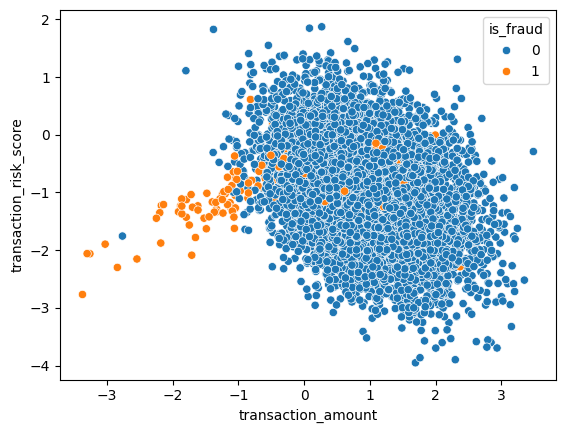

In [12]:
sns.scatterplot(x=X["transaction_amount"], y=X["transaction_risk_score"], hue=y)

plt.show()

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, test_size=0.25)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
model = LogisticRegression()

In [18]:
#Hyperparameter tuning

penalty = ["l1", "l2", "elasticnet"]
c_values = [100,10,1,0.1,0.01]
solver = ["newton-cg", "lbfgs", "liblinear", "sag", "saga", "newton-cholesky"]
class_weights = [{0:w, 1:y} for w in [1,10,50,100] for y in [1,10,50,100]]

In [19]:
class_weights

[{0: 1, 1: 1},
 {0: 1, 1: 10},
 {0: 1, 1: 50},
 {0: 1, 1: 100},
 {0: 10, 1: 1},
 {0: 10, 1: 10},
 {0: 10, 1: 50},
 {0: 10, 1: 100},
 {0: 50, 1: 1},
 {0: 50, 1: 10},
 {0: 50, 1: 50},
 {0: 50, 1: 100},
 {0: 100, 1: 1},
 {0: 100, 1: 10},
 {0: 100, 1: 50},
 {0: 100, 1: 100}]

In [20]:
params = dict(penalty=penalty, C=c_values, solver=solver, class_weight=class_weights)

In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [23]:
cv = StratifiedKFold()

grid = GridSearchCV(cv=cv, estimator=model, scoring="accuracy", param_grid=params)

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 50}, {0: 1, 1: 100},
                                          {0: 10, 1: 1}, {0: 10, 1: 10},
                                          {0: 10, 1: 50}, {0: 10, 1: 100},
                                          {0: 50, 1: 1}, {0: 50, 1: 10},
                                          {0: 50, 1: 50}, {0: 50, 1: 100},
                                          {0: 100, 1: 1}, {0: 100, 1: 10},
                                          {0: 100, 1: 50}, {0: 100, 1: 100}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga', 'newton-cholesky']},
             scoring='accuracy')

In [26]:
grid.best_params_

{'C': 0.01,
 'class_weight': {0: 10, 1: 50},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [27]:
grid.best_score_

np.float64(0.9884000000000001)

In [28]:
y_pred = grid.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [30]:
score = accuracy_score(y_test, y_pred)
print("Score:", score)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Score: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2462
           1       0.84      0.42      0.56        38

    accuracy                           0.99      2500
   macro avg       0.92      0.71      0.78      2500
weighted avg       0.99      0.99      0.99      2500

Confusion Matrix:
 [[2459    3]
 [  22   16]]


In [31]:
#ROC, AUC

The ROC Curve is a graphical representation of a classification model’s performance across different threshold(>=0.5 = 1, <0.5 = 0) values. It plots the True Positive Rate (Recall) on the Y-axis against the False Positive Rate (1 - Specificity) on the X-axis. • A model that perfectly distinguishes between classes has a curve that reaches the top-left corner. • The closer the curve is to the top-left, the better the model. • The area under the ROC curve (AUC) quantifies this performance: • AUC = 1 → perfect classifier • AUC = 0.5 → random guessing

ROC is especially useful for imbalanced datasets, as it evaluates the model independent of class distribution or threshold.

In [37]:
model_prob = grid.predict_proba(X_test)

In [38]:
model_prob

array([[0.99586436, 0.00413564],
       [0.85287009, 0.14712991],
       [0.952308  , 0.047692  ],
       ...,
       [0.98898975, 0.01101025],
       [0.98454137, 0.01545863],
       [0.99758734, 0.00241266]], shape=(2500, 2))

In [39]:
model_prob = model_prob[:,1] #only get right columns(the 1's), probabilities of fraud(1) class

In [40]:
model_prob

array([0.00413564, 0.14712991, 0.047692  , ..., 0.01101025, 0.01545863,
       0.00241266], shape=(2500,))

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

In [42]:
model_auc = roc_auc_score(y_test, model_prob)

In [44]:
model_auc #gives a value between 0.5 - 1. Closer to 1, better the model performed

0.7392898371029116

In [47]:
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_prob) #returns fpr, tpr, thresholds

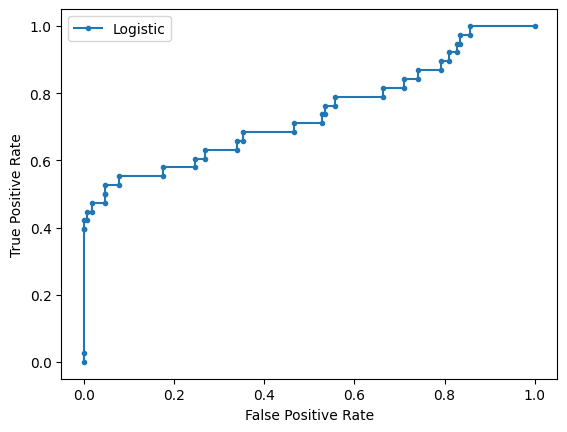

In [49]:
plt.plot(model_fpr, model_tpr, marker = ".", label="Logistic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()

plt.show() #Bigger the spike on true positive rate the better.

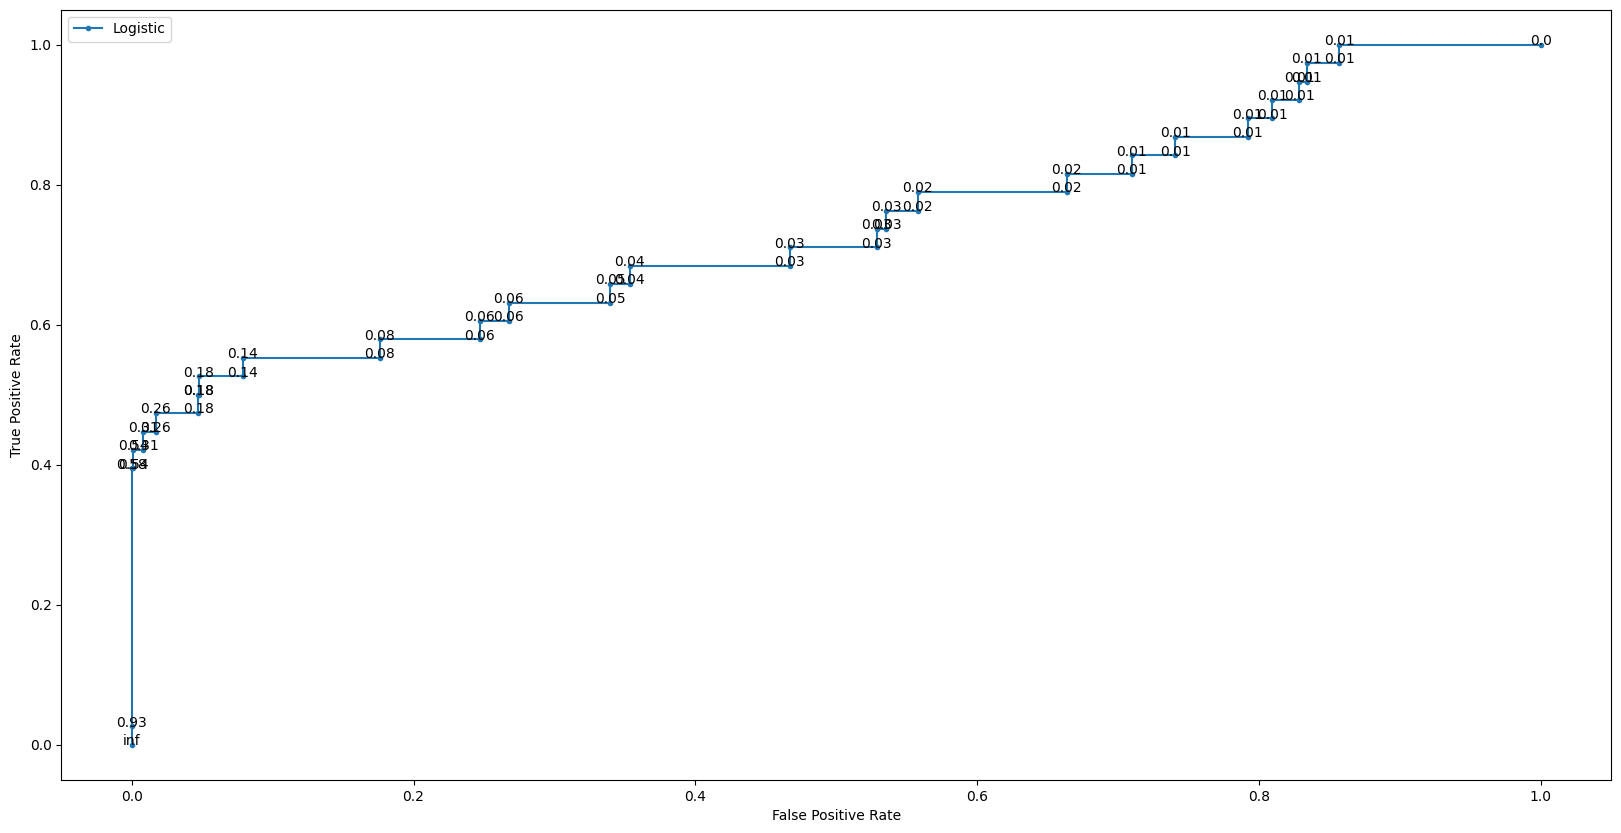

In [50]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(model_fpr, model_tpr, marker = ".", label="Logistic")

for fpr, tpr, thresh in zip(model_fpr, model_tpr, thresholds):
    ax.annotate(f"{np.round(thresh, 2)}", (fpr,tpr), ha="center")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

ax.legend()

plt.show() #Bigger the spike on true positive rate the better.

In [62]:
custom_threshold = 0.5

y_pred_custom = (model_prob >= custom_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

[[2459    3]
 [  22   16]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2462
           1       0.84      0.42      0.56        38

    accuracy                           0.99      2500
   macro avg       0.92      0.71      0.78      2500
weighted avg       0.99      0.99      0.99      2500



In [52]:
y_pred_custom

array([0, 0, 0, ..., 0, 0, 0], shape=(2500,))